### DS-2 PROJECT // MILESTONE 2 SUBMISSION @ UNIV.AI

**Project Title : Alzhiemers Risk Prediciton**

*EDA Notebook 2*

TEAM MEMBERS : $Ajinkya, Chaitanya, Navya , Shibani$

#### Loading basic libararies and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##https://docs.google.com/spreadsheets/d/1CLAAgePXKkayY_KTCFjK4w5_qbi2FUhM/edit?usp=sharing
! gdown --id "1CLAAgePXKkayY_KTCFjK4w5_qbi2FUhM"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CLAAgePXKkayY_KTCFjK4w5_qbi2FUhM
To: /content/oasis_longitudinal_demographics.xlsx
100% 50.7k/50.7k [00:00<00:00, 50.0MB/s]


In [3]:
df = pd.read_excel('/content/oasis_longitudinal_demographics.xlsx')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


####Data Dictionary + Hypothesis Space

| Command | Description |Info | Possible Correlation | 
| --- | --- | --- | --- |
| ID | Patient ID |Nominal,Alphanumeric, use to join | Use to merge and drop
| MRI ID | MRI ID | Nominal,Alphanumeric, use to join|Use to merge and drop
| Group |  indicator for Dementia | Categorical,| Target variable/group
| Visit | visit count | Integer, |  Watch out for models learning "correlations" between certain visit numbers 
| MR Delay |  Days between MR sessions | Integer, | figure out how to deal with sequential visits
| M/F | Biological Sex Indicator| Categorical, mostly binary | F with Group should be higher; We should check wether sex and age clubbed together show a better relationship with GROUP
| Hand | Handedness| Significance = contralateral control via brain + localisation of functions | May yield something in combination
| Age | Patient's age | We could bucket these, we'll probably find 2 significant buckets | EDUC,SES
| EDUC | Level of education | Categorical, 1 through 5  | Target/Group,SES,Age
| SES | The Socio-Economic Status| Categorical, 1 through 5 | Keep in mind, Better access to care/early testing
| MMSE | Mini Mental State Examination| Integer, score 1 to 30 Possible cultural bias and educational bias, | used when deriving CDR. , neg cor with with Target/Group and Age.
| CDR | Clinical Diagnosis Rating| Integer, assigned by Professional | uses MMSE score and MRI info
| eTIV | Total Intercranial Volume (eTIV) of the brain | Integer, unit : mm2| nWBV
| nWBV | Normalized Whole Brain Volume | Integer, unit: mg | eTIV
| ASF | Atlas Scaling Factor| Determinant affine transformation matrix of MRI data points | eTIV, nWBV ; ? Possible proxy incase image data isn't feasible to work with

In [4]:
df.shape

(373, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 43.8+ KB


In [6]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.121584,0.729556,1.195460
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.135956,0.037141,0.138105
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.330000,0.700191,1.098979
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.041312,0.728789,1.193844
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1596.936793,0.755669,1.292980
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


####Checking for Missing Values



In [7]:
df.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [8]:
#in terms of percentage
df.isna().sum()/len(df)

Subject ID    0.000000
MRI ID        0.000000
Group         0.000000
Visit         0.000000
MR Delay      0.000000
M/F           0.000000
Hand          0.000000
Age           0.000000
EDUC          0.000000
SES           0.050938
MMSE          0.005362
CDR           0.000000
eTIV          0.000000
nWBV          0.000000
ASF           0.000000
dtype: float64

None of the features on first pass examination have >5.1% missing values. We've still got to exmaine the object-type and numeric features to check for abnormal/irregular/extreme-value entries.

#### Exploring Further

Since the column `SES` has missing values, let's have a deeper look at it.

In [9]:
df['SES'].unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

Seems like the column has a float encoding but all possible values this data takes is that of whole numbers.

Info about the MMSE:


1. How is the MMSE scored?
- The maximum score for the MMSE is 30. A score of 25 or higher is classed as normal. If the score is below 24, the result is usually considered to be abnormal, indicating possible cognitive impairment.

2. What are the limitations of the MMSE?
- There are limitations to the MMSE which means that your doctor or healthcare professional will take care when interpreting the results.

- A high MMSE score does not necessarily mean that you don’t have cognitive impairment. Similarly, a low score does not necessarily mean that you have dementia. Sometimes, certain physical disabilities, language, speech, education level or cultural differences can affect the score.

- For example, a highly educated person with dementia might still score highly, especially early in their disease.

- Your doctor will take this into account when interpreting the results and they will advise if they think you should have further tests or assessments. An MMSE is just one part of a diagnosis of cognitive impairment or dementia.

###In isolation, it will not diagnose you with any disease, such as dementia

source: https://www.healthdirect.gov.au/mini-mental-state-examination-mmse

In [10]:
sorted(df['MMSE'].unique()), df['MMSE'].nunique()

([4.0,
  7.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  nan],
 18)

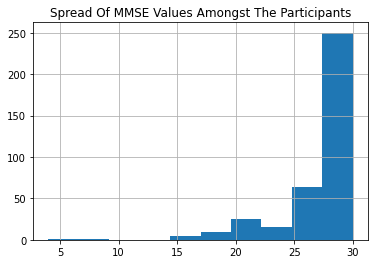

In [11]:
plt.title('Spread Of MMSE Values Amongst The Participants')
df['MMSE'].hist();


From 4-15 there seem to be holes in data. That prompts us to a question, do low values indicate a high degree of severity? or is there an enviromental bias that makes these ranges to have missing values? or is it random?

In [12]:
df.groupby("Group")['MMSE'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Converted,37.0,28.675676,1.564432,24.0,28.0,29.0,30.0,30.0
Demented,144.0,24.513889,4.497064,4.0,22.0,26.0,28.0,30.0
Nondemented,190.0,29.226316,0.882722,26.0,29.0,29.0,30.0,30.0


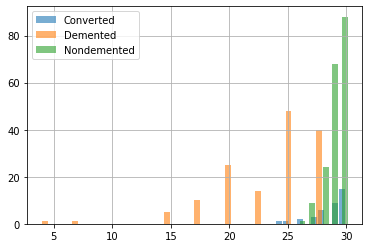

In [13]:
df.groupby("Group")['MMSE'].hist(alpha=0.6, legend=True, width=0.5);

The charts correspond to our initial expectation of what the feature values imply.

In [14]:
df.groupby("Group")['SES'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Converted,37.0,1.729730,0.961730,1.0,1.0,1.0,2.0,4.0
Demented,127.0,2.771654,1.196483,1.0,2.0,3.0,4.0,5.0
Nondemented,190.0,2.394737,1.047534,1.0,2.0,2.0,3.0,5.0


the reason we look for similarities across groups is to get an idea on whether `SES` is provides a "all else equal" state.

Text(0, 0.5, 'Count')

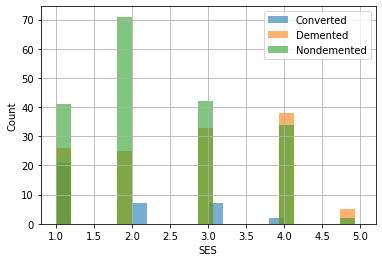

In [15]:
df.groupby("Group")['SES'].hist(alpha=0.6, bins=15, legend=True, width=0.2);
plt.xlabel("SES")
plt.ylabel("Count")

Let's declutter the overlap

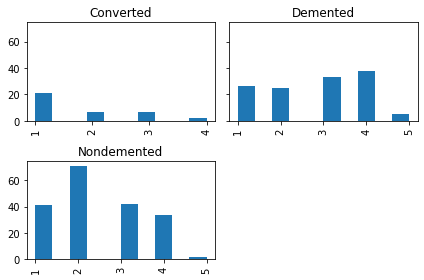

In [16]:
df.hist('SES',by='Group', sharey=True)
plt.tight_layout()

In [17]:
df[df.SES.isna()].describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,19.000000,19.000000,19.000000,19.000000,0.0,17.000000,19.000000,19.000000,19.000000,19.000000
mean,1.842105,478.684211,76.631579,12.631579,NaN,25.941176,0.657895,1453.362766,0.723821,1.226740
std,0.898342,532.258088,3.112886,1.498537,NaN,2.726504,0.238783,184.346122,0.019520,0.160954
min,1.000000,0.000000,71.000000,12.000000,NaN,20.000000,0.500000,1158.567258,0.696097,1.010000
25%,1.000000,0.000000,75.000000,12.000000,NaN,23.000000,0.500000,1336.850000,0.706862,1.089894
50%,2.000000,518.000000,76.000000,12.000000,NaN,27.000000,0.500000,1453.050000,0.726850,1.207810
75%,2.000000,673.000000,79.000000,12.000000,NaN,27.000000,1.000000,1611.364473,0.736662,1.313095
max,4.000000,1895.000000,83.000000,16.000000,NaN,30.000000,1.000000,1737.620000,0.762489,1.514802


quick note: the 2 missing `MMSE` values occur only when the `SES` value is missing too.

In [18]:
df[df.SES.notna()].describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,1.884181,601.353107,77.033898,14.703390,2.460452,27.409605,0.271186,1489.987170,0.729863,1.193782
std,0.925330,640.596081,7.811808,2.895662,1.134005,3.712626,0.370537,175.762130,0.037847,0.136833
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1358.047821,0.698730,1.100214
50%,2.000000,559.500000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.457128,0.729113,1.193506
75%,2.000000,882.500000,82.000000,16.750000,3.000000,30.000000,0.500000,1595.150095,0.756883,1.292297
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


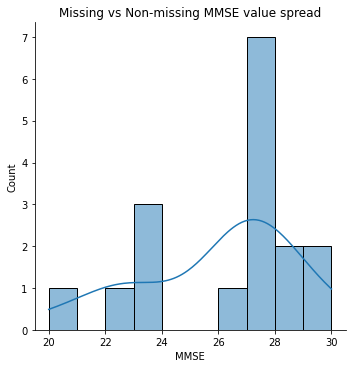

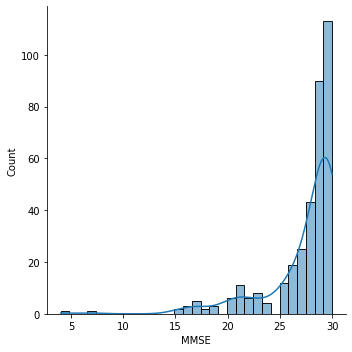

In [19]:

sns.displot(df[df.SES.isna()].MMSE, kde=True, bins=10);
plt.title("Missing vs Non-missing MMSE value spread")
sns.displot(df[df.SES.notna()].MMSE, kde=True);


The above kde-plots are just to show how densities can be misleading at times when there are holes in the data.

Post our quick analysis on variables with missing values and what the possible reasons could be, we can now move ahead with this understanding to the exploratory analysis of the other varaibles and how they interact with eachother in general.

We could also probably take a look at t-tests to examine if the differences across missing/non-missing values are significant, and if yes, to what degree?

We could in a general case discard missing data given that it falls below the arbitrary 5% threshold but since medical data is precious, it's worth a try to see if there is any reason for it to happen given that we had no control over the data collection process.

####Basic Correlations



In [20]:
#basic correlations
df.corr()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Visit,1.000000,0.920009,0.183213,0.024615,-0.051622,-0.029078,0.002325,0.117423,-0.125826,-0.120439
MR Delay,0.920009,1.000000,0.205357,0.051630,-0.030813,0.065844,-0.062915,0.119641,-0.104737,-0.123615
Age,0.183213,0.205357,1.000000,-0.027886,-0.046857,0.055612,-0.026257,0.042401,-0.518546,-0.034845
EDUC,0.024615,0.051630,-0.027886,1.000000,-0.722647,0.194884,-0.153121,0.257042,-0.012300,-0.241696
SES,-0.051622,-0.030813,-0.046857,-0.722647,1.000000,-0.149219,0.076160,-0.261582,0.089956,0.255448
MMSE,-0.029078,0.065844,0.055612,0.194884,-0.149219,1.000000,-0.686519,-0.032088,0.341912,0.040145
CDR,0.002325,-0.062915,-0.026257,-0.153121,0.076160,-0.686519,1.000000,0.022863,-0.344873,-0.029426
eTIV,0.117423,0.119641,0.042401,0.257042,-0.261582,-0.032088,0.022863,1.000000,-0.209875,-0.988868
nWBV,-0.125826,-0.104737,-0.518546,-0.012300,0.089956,0.341912,-0.344873,-0.209875,1.000000,0.213073
ASF,-0.120439,-0.123615,-0.034845,-0.241696,0.255448,0.040145,-0.029426,-0.988868,0.213073,1.000000


#### Checking balance in Data

In [21]:
df.Group.value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

In [22]:
df.Visit.value_counts()

1    150
2    144
3     58
4     15
5      6
Name: Visit, dtype: int64

In [23]:
df["M/F"].value_counts()

F    213
M    160
Name: M/F, dtype: int64

Dropping MRI ID, as we arent merging and data right now, Dropping Hand ( Handedness) as our data only consisted of right handed people. No real value would be added untill the time we coraborate with other comparable sources which inluded left handedness, mixedhandedness and ambidexterity.

In [24]:
df.drop(["MRI ID", "Hand"], axis=1,inplace=True)

In [25]:
df.columns

Index(['Subject ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES',
       'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [26]:
df["M/F"] = df["M/F"].replace(["M","F"], [1,0])

In [27]:
df.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,Demented,1,0,1,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,Demented,2,560,1,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,Demented,3,1895,1,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


####Spread of the Target Variable

Text(0.5, 1.0, 'Categories of Patients')

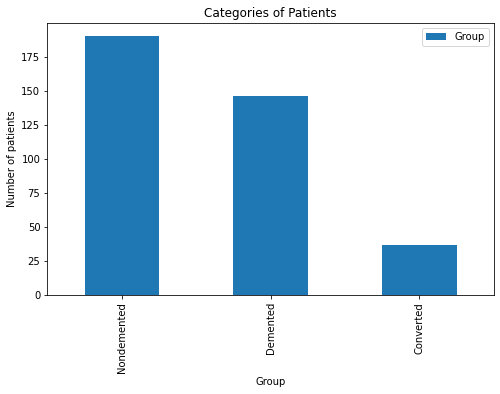

In [28]:
df["Group"].value_counts().plot(kind='bar',figsize=(8,5))
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Categories of Patients')

Exploring Biological Sex Further , when target value is positive ("Demented" / "Converted"). 

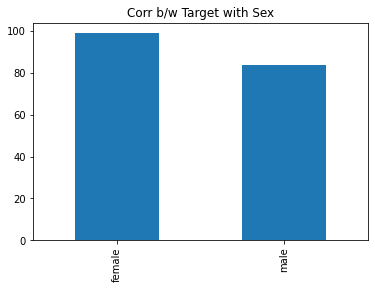

In [29]:
df[(df["Group"]=="Converted") | (df["Group"]=="Demented")]["M/F"].value_counts().plot(kind="bar")
plt.xticks(np.arange(2),["female","male"])
plt.title("Corr b/w Target with Sex")
plt.show()

Exploring “Converted” I.e. change in the Target Variable and Demented groups of patients w.r.t gender. The plot states that female data is higher in these categories. 


       0   1
M/F  129  61
M/F   60  86
M/F   24  13


Text(0.5, 1.0, 'Gender and Demented rate')

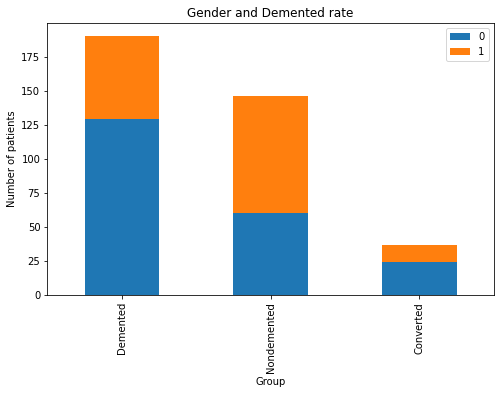

In [30]:
Demented = df[df['Group']=="Nondemented"]["M/F"].value_counts()
Nondemented = df[df['Group']=="Demented"]["M/F"].value_counts()
Converted = df[df['Group']=="Converted"]["M/F"].value_counts()
df_bar = pd.DataFrame([Demented,Nondemented,Converted])
print(df_bar)
df_bar.index = ['Demented','Nondemented',"Converted"]
df_bar.plot(kind='bar',stacked=True, figsize=(8,5))
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

Note : 0 is female and  1 is male here

we can see that our datacontains more instances of females with the diagnosis than males. While keeping in mind that the dataset is not balanced to begin with, this observation does stand true with the literature on the disease. Research indices females are much more likely to be diagnosed with Alzhimers'. 

#### Visualising Distributions

(50.0, 100.0)

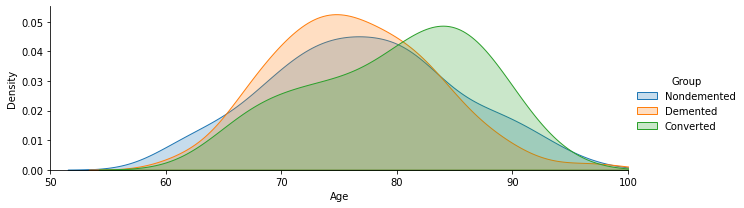

In [31]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

Plotting the distribution of age for different categories of target variable. 

Text(0.5, 1.0, 'Distribution of Educational qualifications among different groups')

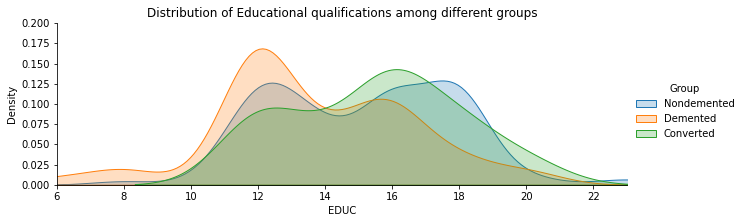

In [32]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.2)
plt.title("Distribution of Educational qualifications among different groups")

Popele with dementia are observed to have lower level of education compared to other categories. This is in line with our initial hypotheses based on medical literature suggesting further education and increased cognitive “exercise" may act as a preventative or protective measure.


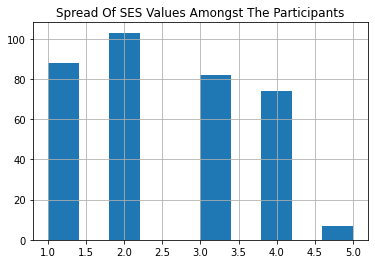

In [33]:
plt.title('Spread Of SES Values Amongst The Participants')
df['SES'].hist();

SES with value "2.0" is most common and "5.0" is least common

In [34]:
df["CDR"].value_counts()

0.0    206
0.5    123
1.0     41
2.0      3
Name: CDR, dtype: int64

(0.5, 2.0)

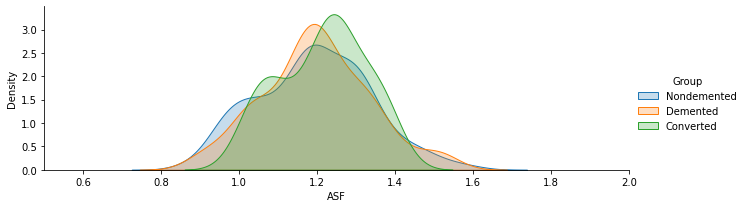

In [35]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

(900.0, 2100.0)

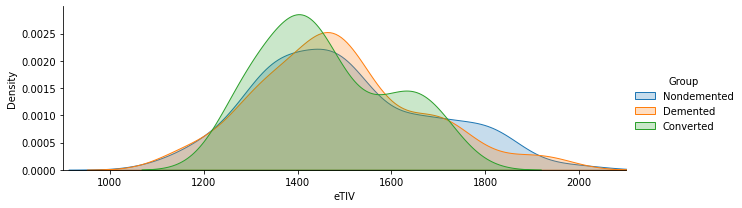

In [36]:
#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

(0.6, 0.9)

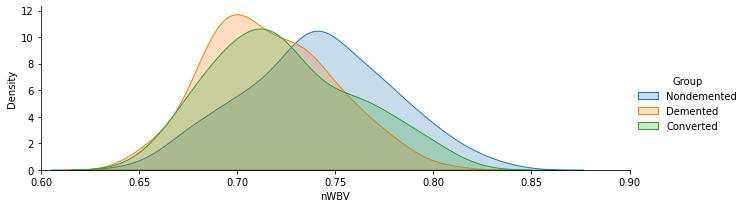

In [37]:
#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

     0.0  0.5  1.0  2.0
CDR   64   73   22    1
CDR  142   50   19    2


Text(0.5, 1.0, 'Gender and CDR rate')

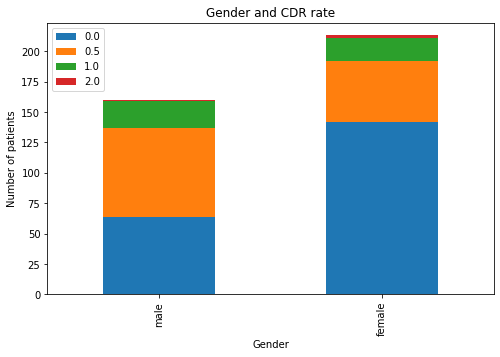

In [38]:
male = df[df['M/F']==1]["CDR"].value_counts()
female = df[df['M/F']==0]["CDR"].value_counts()
df_bar = pd.DataFrame([male,female])
print(df_bar)
df_bar.index = ["male","female"]
df_bar.plot(kind='bar',stacked=True, figsize=(8,5))
plt.xlabel('Gender')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and CDR rate')

Facet plots are inspired from https://www.kaggle.com/code/hyunseokc/detecting-early-alzheimer-s/notebook

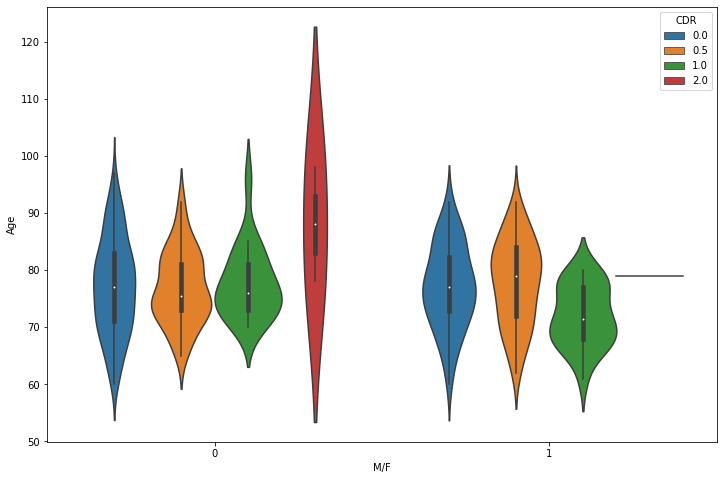

In [39]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="Age",hue="CDR",data=df)
plt.show()

The severity of disease is more in females. 

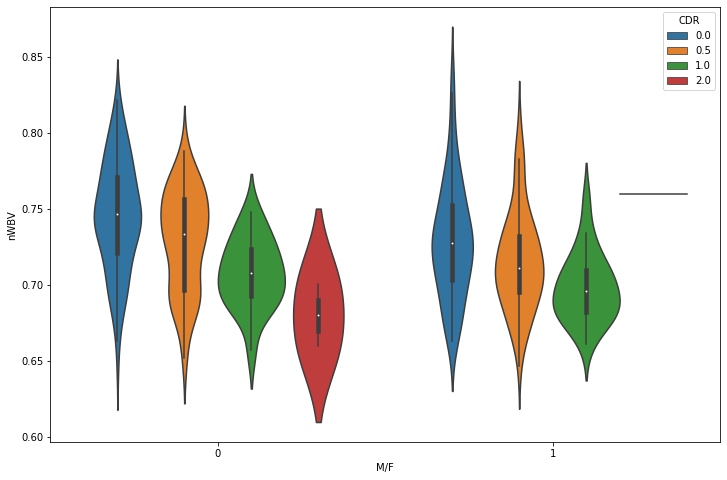

In [40]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="nWBV",hue="CDR",data=df)
plt.show()

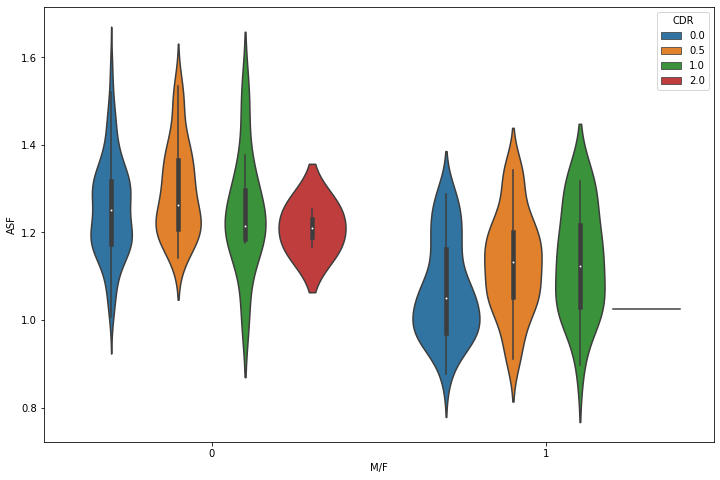

In [41]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="ASF",hue="CDR",data=df)
plt.show()

Looking at the CDR score of 2 , indicating Moderate Cognitive Impairment, we can infer that only females were given this score. Based on that ,for the scope of our data ,we can say speculatively that the severity of the disease is more for the females. We would be looking into literature to confirm this if we explore this space further.


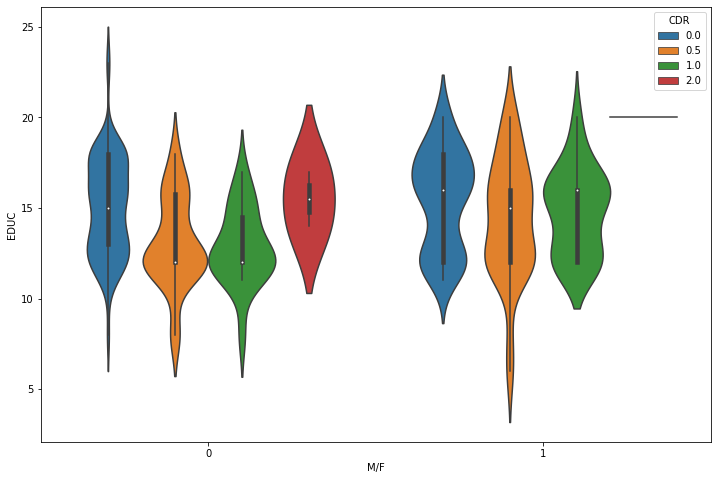

In [42]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="EDUC",hue="CDR",data=df)
plt.show()

Men have higher levels of education as severety of dementia increases. 

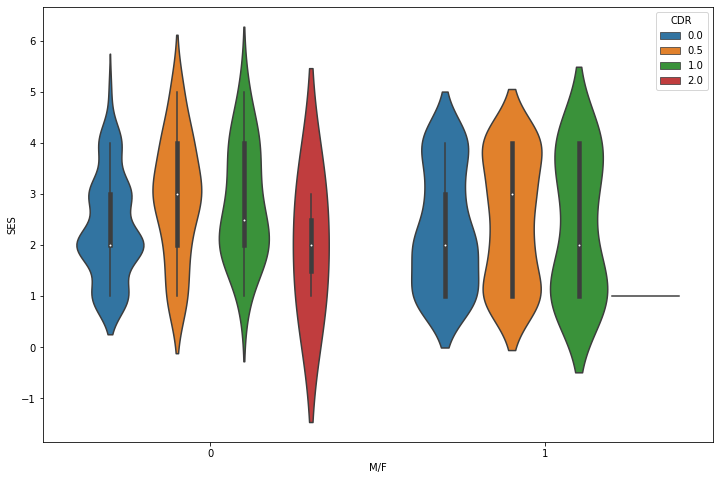

In [43]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="SES",hue="CDR",data=df)
plt.show()

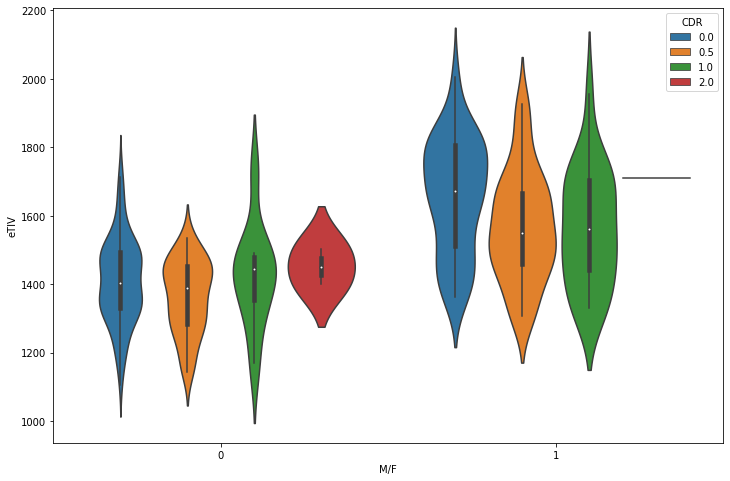

In [44]:
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="M/F", y="eTIV",hue="CDR",data=df)
plt.show()

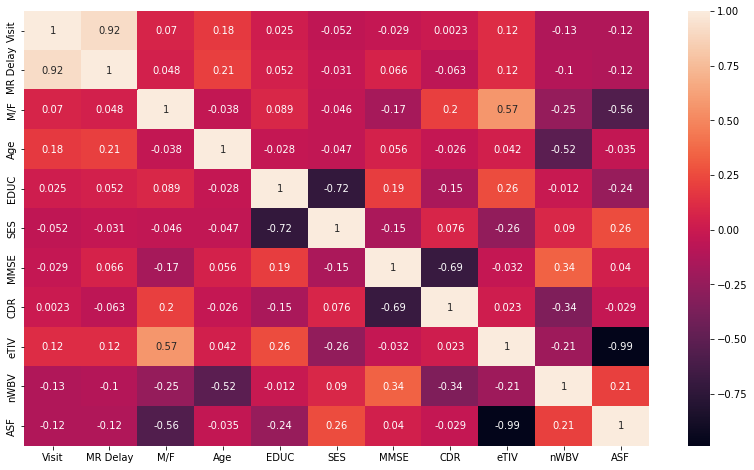

In [45]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

Some of these correlations are understandable such as Education and SES.  ( Social linkage) , (*insert brain volume column names here*) as they are all related measures of brain volume. CDR and MMSE and MMSE is used to derive CDR.These also stand in line with our initial hypotheses



In [46]:
df.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,Demented,1,0,1,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,Demented,2,560,1,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,Demented,3,1895,1,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [47]:
print("The shape of the dataframe is ",df.shape)
print("The unique data types in the dataframe are ",df.dtypes.unique())

The shape of the dataframe is  (373, 13)
The unique data types in the dataframe are  [dtype('O') dtype('int64') dtype('float64')]


In [48]:
missing_values = pd.DataFrame(df.isnull().sum(), columns=["Number of missing values"])
missing_values["Percentage of missing values"] = 100*missing_values["Number of missing values"]/(df.shape[0])
missing_values

,Number of missing values,Percentage of missing values
Subject ID,0,0.000000
Group,0,0.000000
Visit,0,0.000000
MR Delay,0,0.000000
M/F,0,0.000000
Age,0,0.000000
EDUC,0,0.000000
SES,19,5.093834
MMSE,2,0.536193
CDR,0,0.000000
